### Find accuracy of using xgboost on the loan data

In [1]:
import numpy as np
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib


### Load the data

In [2]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

### Split the training data into training and validation data

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    stratify=y_train,
    random_state=42
)

### Build the xgboost model

In [4]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    eval_metric='aucpr',
    random_state=42
)

In [5]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-aucpr:0.99494
[1]	validation_0-aucpr:0.99494
[2]	validation_0-aucpr:0.99472
[3]	validation_0-aucpr:0.99901
[4]	validation_0-aucpr:0.99895
[5]	validation_0-aucpr:0.99888
[6]	validation_0-aucpr:0.99915
[7]	validation_0-aucpr:0.99908
[8]	validation_0-aucpr:0.99968
[9]	validation_0-aucpr:0.99952
[10]	validation_0-aucpr:0.99968
[11]	validation_0-aucpr:0.99984
[12]	validation_0-aucpr:0.99989
[13]	validation_0-aucpr:0.99991
[14]	validation_0-aucpr:0.99991
[15]	validation_0-aucpr:0.99991
[16]	validation_0-aucpr:0.99991
[17]	validation_0-aucpr:0.99989
[18]	validation_0-aucpr:0.99991
[19]	validation_0-aucpr:0.99996
[20]	validation_0-aucpr:0.99993
[21]	validation_0-aucpr:0.99989
[22]	validation_0-aucpr:0.99993
[23]	validation_0-aucpr:0.99996
[24]	validation_0-aucpr:0.99996
[25]	validation_0-aucpr:0.99993
[26]	validation_0-aucpr:0.99993
[27]	validation_0-aucpr:0.99998
[28]	validation_0-aucpr:0.99996
[29]	validation_0-aucpr:0.99996
[30]	validation_0-aucpr:0.99998
[31]	validation_0-

/opt/anaconda3/envs/tf-mac/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:15:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Evaluate the model accuracy using test data

In [6]:

y_pred = xgb_model.predict(X_test)


              precision    recall  f1-score   support

           0      0.994     0.988     0.991       323
           1      0.992     0.996     0.994       531

    accuracy                          0.993       854
   macro avg      0.993     0.992     0.993       854
weighted avg      0.993     0.993     0.993       854



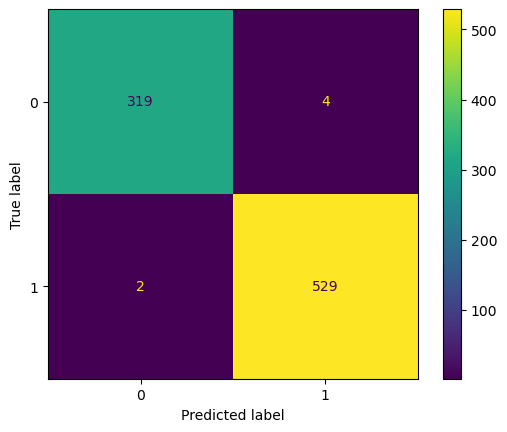

In [7]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred, digits=3))

In [8]:
print("Model accuracy:", xgb_model.score(X_test, y_test))

Model accuracy: 0.9929742388758782


### Comparing Logistics Regression to XGboost, XGboost has the higher accuracy

In [9]:
joblib.dump(xgb_model, 'loan_xgb_model.pkl') # Save the model for future use

['loan_xgb_model.pkl']

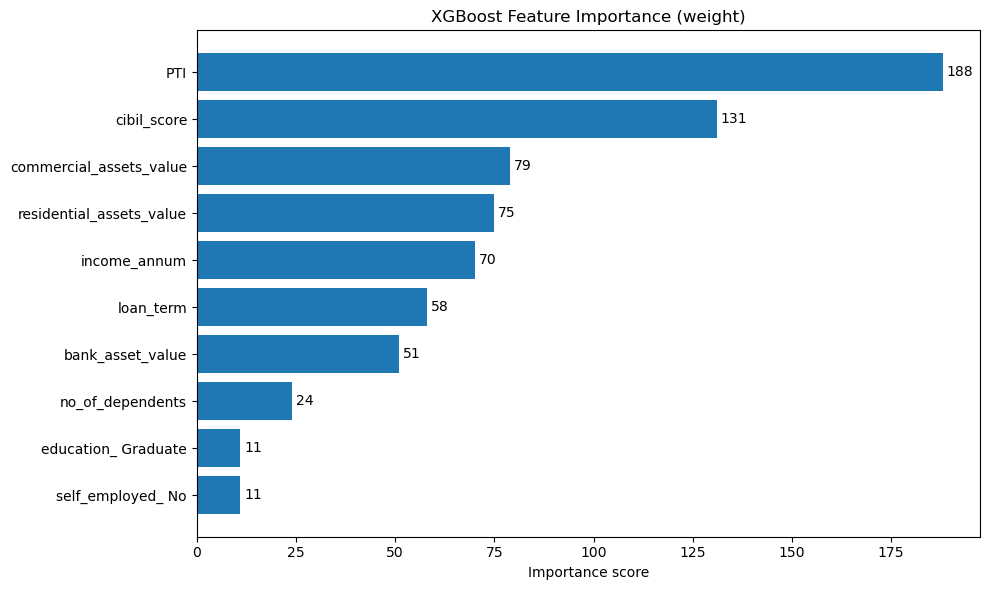

In [10]:
import matplotlib.pyplot as plt
raw_scores = xgb_model.get_booster().get_score(importance_type='weight')
final_feature_names = ['no_of_dependents',
 'PTI',
 'income_annum',
 'loan_term',
 'cibil_score',
 'residential_assets_value',
 'commercial_assets_value',
 'bank_asset_value',
 'education_ Graduate',
 'education_ Not Graduate',
 'self_employed_ No',
 'self_employed_ Yes']

mapped_scores = {
    final_feature_names[int(k[1:])]: v
    for k, v in raw_scores.items()
    if int(k[1:]) < len(final_feature_names)
}
sorted_scores = sorted(mapped_scores.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_scores)

plt.figure(figsize=(10, 6))
bars = plt.barh(features, scores, color='#1f77b4')
plt.xlabel("Importance score")
plt.title("XGBoost Feature Importance (weight)")
for bar, score in zip(bars, scores):
    plt.text(score + 1, bar.get_y() + bar.get_height() / 2, f"{score:.0f}", va='center')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


/opt/anaconda3/envs/tf-mac/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


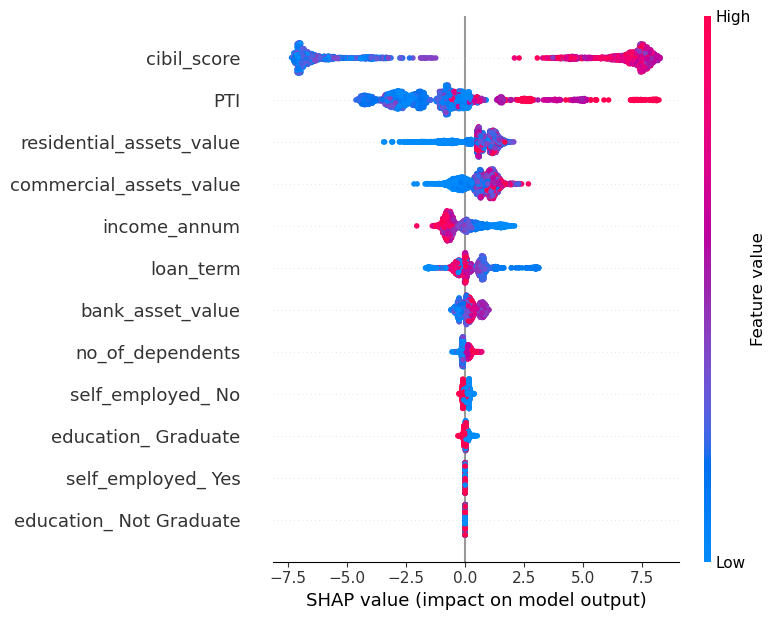

In [11]:
import shap
import pandas as pd
X_df = pd.DataFrame(X_train, columns=final_feature_names)
# Create SHAP explainer optimized for tree models
explainer = shap.TreeExplainer(xgb_model)
# Compute SHAP values
shap_values = explainer.shap_values(X_df)
# Plot SHAP summary (dot plot) with correct names
shap.summary_plot(shap_values, X_df)